# Homework 3 
# Financial Time series prediction
# Paul Faverjon

## 1) 

In [1]:
# Imporing modules


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import yfinance as yf
from sklearn.model_selection import train_test_split


In [2]:

# Define the ticker symbols
tickers = ["AMZN", "NCLH"]

# Define the period
start_date = '2016-01-01'
end_date = '2020-12-31'

# Fetch daily data
data = yf.download(tickers, start=start_date, end=end_date, group_by="ticker", interval='1d')

[*********************100%***********************]  2 of 2 completed


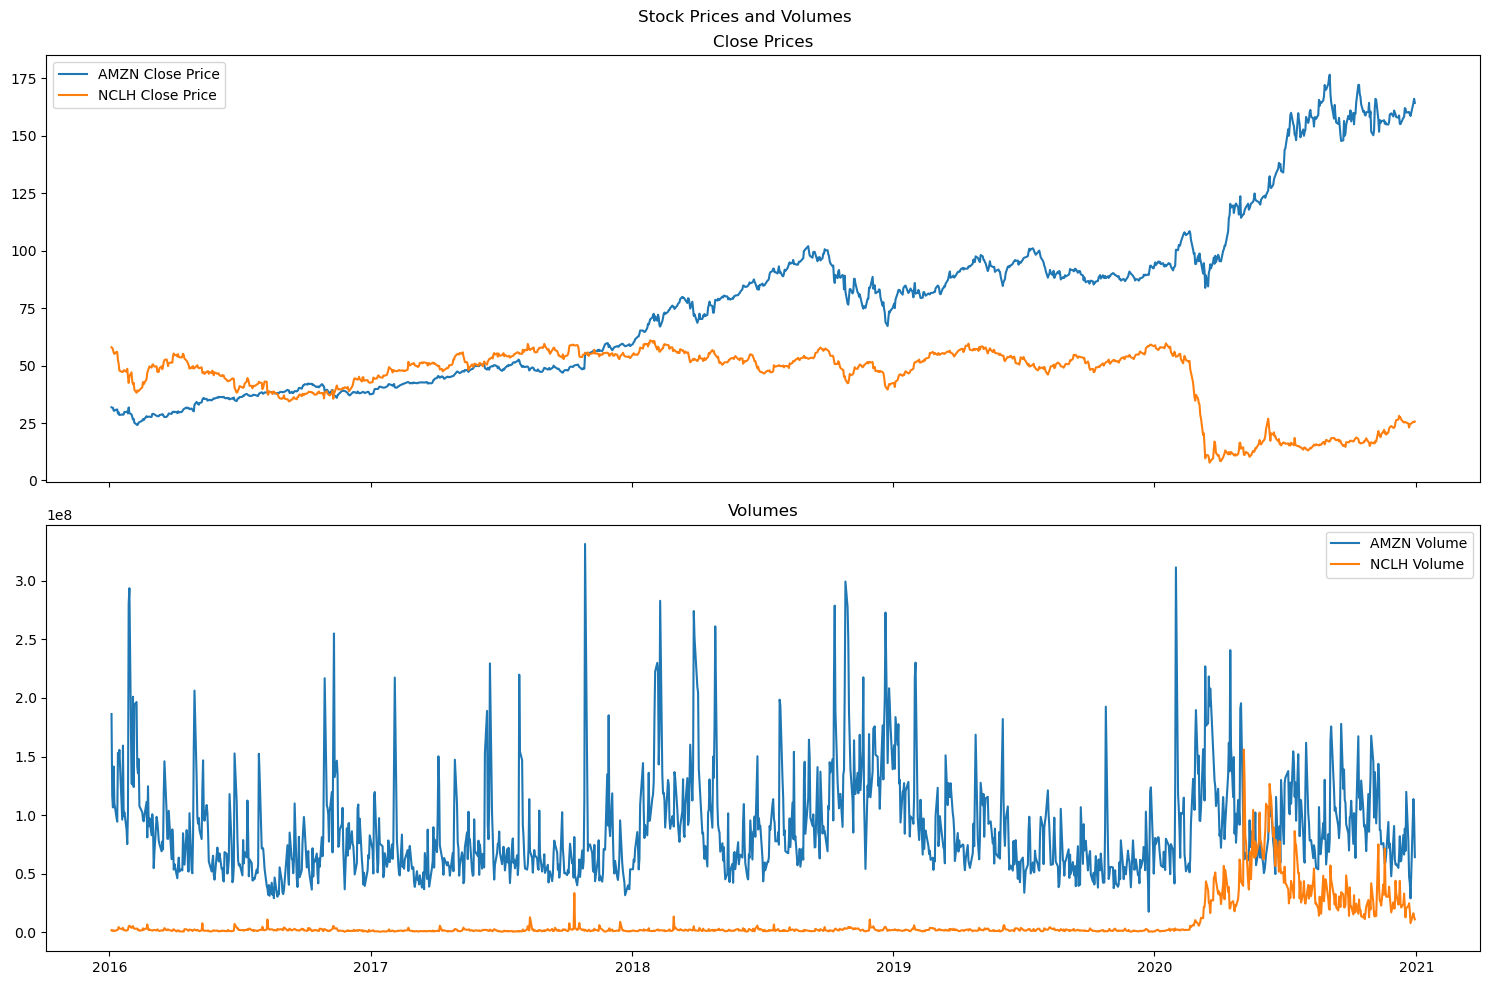

In [3]:

# Plot the close prices

fig, axs = plt.subplots(figsize=(15, 10), nrows=2, ncols=1, sharex=True)
axs.flatten()
axs[0].plot(data['AMZN']['Close'], label='AMZN Close Price')
axs[0].plot(data['NCLH']['Close'], label='NCLH Close Price')
axs[0].set_title('Close Prices')
axs[0].legend(loc='upper left')

# Plot the volumes

axs[1].plot(data['AMZN']['Volume'], label='AMZN Volume')
axs[1].plot(data['NCLH']['Volume'], label='NCLH Volume')
axs[1].set_title('Volumes')
axs[1].legend(loc='upper right')


plt.suptitle('Stock Prices and Volumes')
plt.tight_layout()
plt.show()




In [4]:
# Creating a dictionary to hold the summary statistics
summary_stats = {
    'AMZN 2019': data['AMZN']['Volume'].loc['2019-01-01':'2019-12-31'].describe(),
    'NCLH 2019': data['NCLH']['Volume'].loc['2019-01-01':'2019-12-31'].describe(),
    'AMZN 2020': data['AMZN']['Volume'].loc['2020-01-01':'2020-12-31'].describe(),
    'NCLH 2020': data['NCLH']['Volume'].loc['2020-01-01':'2020-12-31'].describe()
}

# Transforming the summary statistics into a pandas DataFrame
summary_stats_df = pd.DataFrame(summary_stats).transpose().drop(columns=['count', 'min', '25%', '75%'])

# Showing the DataFrame
summary_stats_df.head()

,mean,std,50%,max
AMZN 2019,7.735318e+07,3.228133e+07,69516000.0,230124000.0
NCLH 2019,1.976160e+06,9.109656e+05,1723400.0,6167200.0
AMZN 2020,9.877647e+07,3.952310e+07,90562000.0,311346000.0
NCLH 2020,3.332906e+07,2.691557e+07,27309000.0,155971800.0


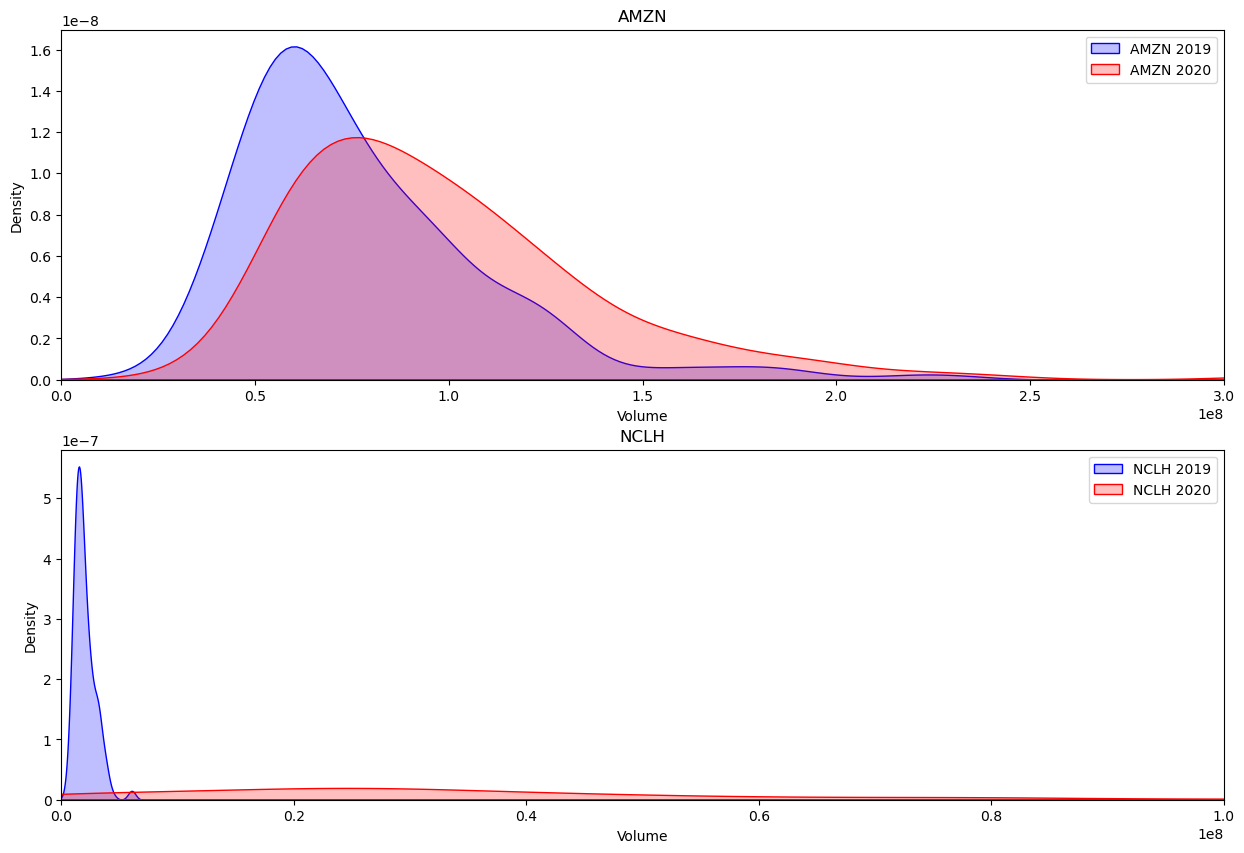

In [5]:
import seaborn as sns

fig, axs = plt.subplots(figsize=(15, 10), nrows=2, ncols=1)
axs.flatten()
sns.kdeplot(
    data['AMZN']['Volume'].loc['2019-01-01':'2019-12-31'], 
    label='AMZN 2019', 
    fill = True, color ='b', 
    ax=axs[0])

sns.kdeplot(
    data['AMZN']['Volume'].loc['2020-01-01':'2020-12-31'], 
    label='AMZN 2020', 
    fill = True, color ='r', 
    ax=axs[0])


sns.kdeplot(
    data['NCLH']['Volume'].loc['2019-01-01':'2019-12-31']
    ,label='NCLH 2019',
    fill = True, color = 'b',  
    ax=axs[1])

sns.kdeplot(
    data['NCLH']['Volume'].loc['2020-01-01':'2020-12-31']
    ,label='NCLH 2020',
    fill = True, color = 'r',  
    ax=axs[1])

axs[0].set_xlim(0, 3*10**8)
axs[1].set_xlim(0, 10**8)

axs[0].set_title('AMZN')
axs[0].legend(loc='upper right',)
axs[1].set_title('NCLH')
axs[1].legend(loc='upper right')




- AMZN price: CLassic behaviour, clear upwards trend, increased volatility and stronger bearish trend during covis. 
- NCHL price: very low volatility and no clear trend before Covid. Very sharp drop at the beginning of the crisis due to the fact that it is a travel company. To predict prices well, a model should be able to capture the change in volatility.

- AMZN volume : Small distributional change during covid, global increase in  volume
- NCHL volume : Very strong distributional change. Very strong avergae increase in volume during covid (not the same order of magnitude, as multiplid by 10), but very low volume before. Especially, the volatility of volume increased greatly (std_dev multiplied by 20). To predict volume well, a model should be able to capture the change in volatility.



## 2)

In [6]:
#using N -day sliding window, use N -day average and N -day median methods to
#predict daily stock volumes for N + 1st day in 2019 and 2020 for N = 10, 30, 60


# Define the window size
window_sizes = [10, 30, 60]

ama_vol = data['AMZN'][['Volume']].copy()
nclh_vol = data['NCLH'][['Volume']].copy()
ama_vol = ama_vol.loc['2019-01-01':'2020-12-31']
nclh_vol = nclh_vol.loc['2019-01-01':'2020-12-31']
ama_vol['shifted'] = ama_vol['Volume'].shift(-1)
nclh_vol['shifted'] = nclh_vol['Volume'].shift(-1)

for window in window_sizes : 
    ama_vol[f'mean_{window}'] = ama_vol['shifted'].rolling(window=window).mean()
    ama_vol[f'median_{window}'] = ama_vol['shifted'].rolling(window=window).median()
    nclh_vol[f'mean_{window}'] = nclh_vol['shifted'].rolling(window=window).mean()
    nclh_vol[f'median_{window}'] = nclh_vol['shifted'].rolling(window=window).median()

# Drop the NaN values
ama_vol.drop(columns=['shifted'], inplace=True)
nclh_vol.drop(columns=['shifted'], inplace=True)

ama_vol = ama_vol.dropna()
nclh_vol = nclh_vol.dropna()
nclh_vol = nclh_vol.loc['2019-01-01':'2020-12-31']
ama_vol = ama_vol.loc['2019-01-01':'2020-12-31']
ama_vol.head()


,Volume,mean_10,median_10,mean_30,median_30,mean_60,median_60
Date,,,,,,,
2019-03-28,60860000,101696000.0,105329000.0,8.720000e+07,78724000.0,1.025959e+08,96963000.0
2019-03-29,66416000,99315400.0,99697000.0,8.712993e+07,78724000.0,1.016836e+08,95239000.0
2019-04-01,84776000,93483200.0,91907000.0,8.697420e+07,78724000.0,9.977213e+07,93532000.0
2019-04-02,68962000,88804200.0,85636000.0,8.736653e+07,79221000.0,9.841643e+07,92998000.0
2019-04-03,78522000,84516400.0,81649000.0,8.746020e+07,79221000.0,9.666393e+07,92594000.0


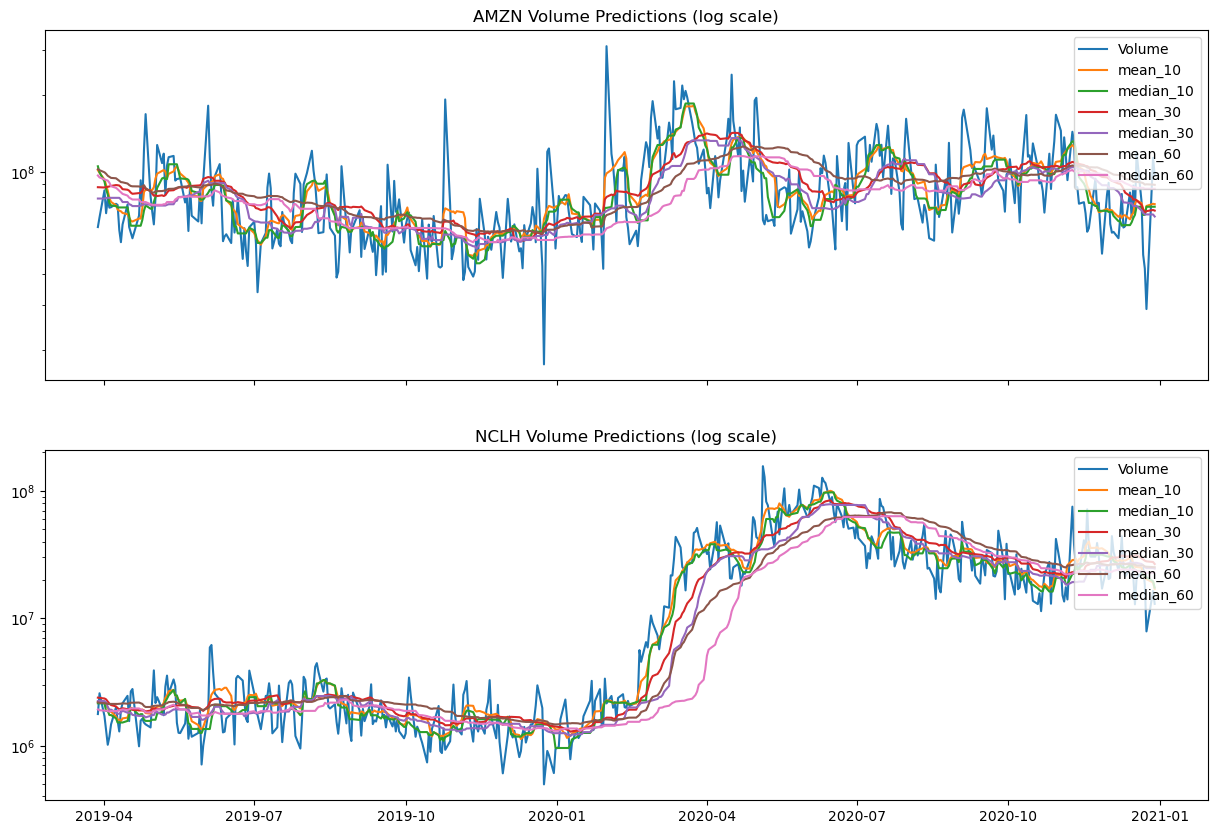

In [7]:
# Plot the results

fig, axs = plt.subplots(figsize=(15, 10), nrows=2, ncols=1, sharex=True)

for column in ama_vol.columns:
    axs[0].plot(ama_vol[column], label=column)
    axs[0].set_yscale('log')
    axs[1].plot(nclh_vol[column], label=column)
    axs[1].set_yscale('log')

axs[0].set_title('AMZN Volume Predictions (log scale)')
axs[0].legend(loc='upper right')
axs[1].set_title('NCLH Volume Predictions (log scale)')
axs[1].legend(loc='upper right')
plt.show()


In [8]:
# Computing the mean absolute error 
from sklearn.metrics import mean_absolute_error 

ama_mse = pd.DataFrame()
nclh_mse = pd.DataFrame()
#Computing mean square errors over each month

for window in window_sizes:
    ama_vol[f'mse_mean_{window}'] = (ama_vol['Volume'] - ama_vol[f'mean_{window}'])**2
    ama_mse[f'mse_mean_{window}'] = ama_vol[f'mse_mean_{window}'].resample('M').mean()

    ama_vol[f'mse_median_{window}'] = (ama_vol['Volume'] - ama_vol[f'median_{window}'])**2
    ama_mse[f'mse_median_{window}'] = ama_vol[f'mse_median_{window}'].resample('M').mean()

    nclh_vol[f'mse_mean_{window}'] = (nclh_vol['Volume'] - nclh_vol[f'mean_{window}'])**2
    nclh_mse[f'mse_mean_{window}'] = nclh_vol[f'mse_mean_{window}'].resample('M').mean()

    nclh_vol[f'mse_median_{window}'] = (nclh_vol['Volume'] - nclh_vol[f'median_{window}'])**2
    nclh_mse[f'mse_median_{window}'] = nclh_vol[f'mse_median_{window}'].resample('M').mean()


    #ama_vol.drop(columns=[f'mse_mean_{window}', f'mse_median_{window}'], inplace=True)
    #nclh_vol.drop(columns=[f'mse_mean_{window}', f'mse_median_{window}'], inplace=True)


In [9]:
ama_mse.head()

,mse_mean_10,mse_median_10,mse_mean_30,mse_median_30,mse_mean_60,mse_median_60
Date,,,,,,
2019-03-31,1.374975e+15,1.542558e+15,5.614313e+14,2.353047e+14,1.492846e+15,1.067096e+15
2019-04-30,5.065883e+14,6.617147e+14,6.931291e+14,6.565140e+14,8.716414e+14,7.631119e+14
2019-05-31,2.554283e+14,2.867826e+14,4.584421e+14,5.988581e+14,4.088278e+14,5.584812e+14
2019-06-30,7.270386e+14,7.607867e+14,9.129003e+14,8.751120e+14,9.693296e+14,9.207904e+14
2019-07-31,2.640707e+14,3.224195e+14,3.380635e+14,3.621726e+14,4.787699e+14,3.848568e+14


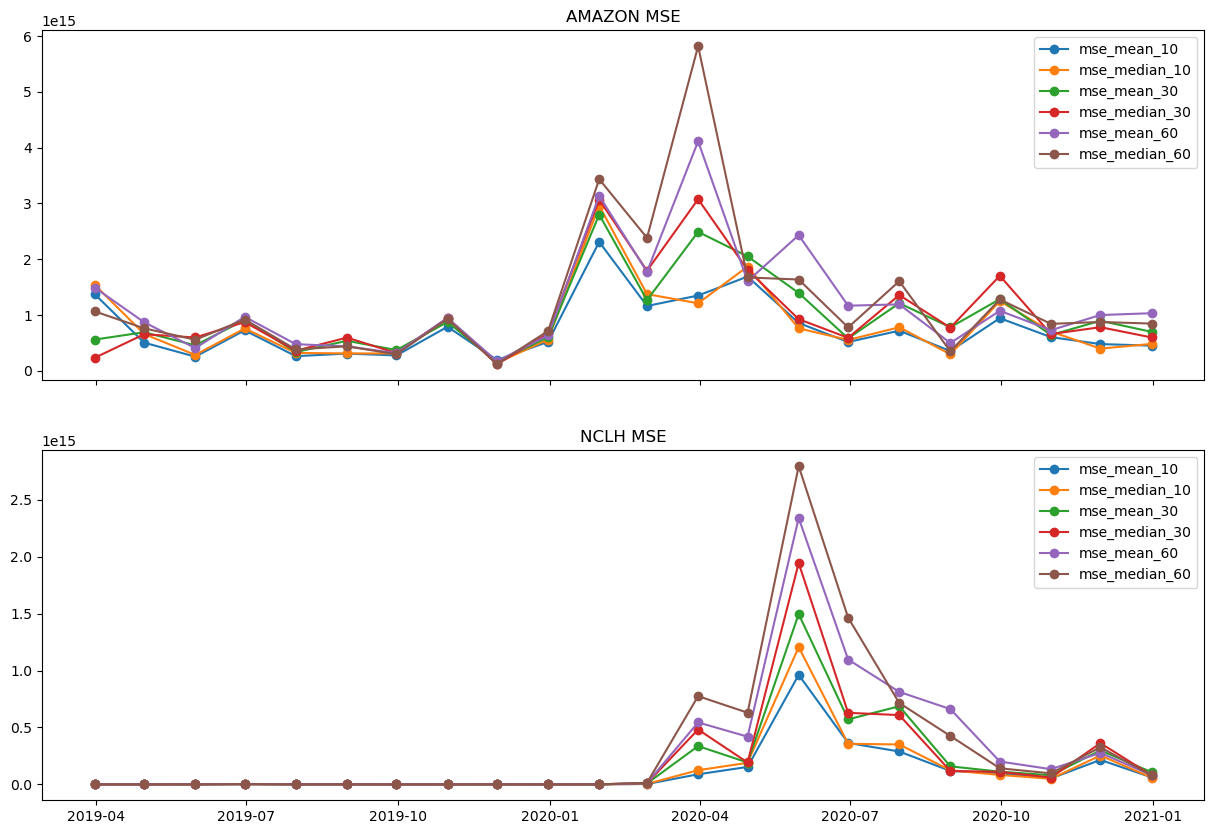

In [10]:
# Plot the results

fig, axs = plt.subplots(figsize=(15, 10), nrows=2, ncols=1, sharex=True)

for column in ama_mse.columns:
    axs[0].plot(ama_mse[column], label=column, marker='o')
    axs[1].plot(nclh_mse[column], label=column, marker='o')

axs[0].set_title('AMAZON MSE')
axs[0].legend(loc='upper right')

axs[1].set_title('NCLH MSE')
axs[1].legend(loc='upper right')

plt.show()

In [11]:
# Banking holidays
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
holidays = cal.holidays(start='2019-01-01', end='2020-12-31').to_pydatetime()

#compute the mse over the days that are not holidays

ama_vol['is_holiday'] = ama_vol.index.isin(holidays)
nclh_vol['is_holiday'] = nclh_vol.index.isin(holidays)



ama_mse_hol = {}
nclh_mse_hol = {}

for window in window_sizes:
    ama_mse_hol[f'mean_{window}_is_hol'] = ama_vol[ama_vol['is_holiday']][f'mse_mean_{window}'].mean()
    ama_mse_hol[f'median_{window}_is_hol'] = ama_vol[ama_vol['is_holiday']][f'mse_median_{window}'].mean()

    ama_mse_hol[f'mean_{window}_not_hol'] = ama_vol[~ama_vol['is_holiday']][f'mse_mean_{window}'].mean()
    ama_mse_hol[f'median_{window}_not_hol'] = ama_vol[~ama_vol['is_holiday']][f'mse_median_{window}'].mean()

    nclh_mse_hol[f'mean_{window}_is_hol'] = nclh_vol[nclh_vol['is_holiday']][f'mse_mean_{window}'].mean()
    nclh_mse_hol[f'median_{window}_is_hol'] = nclh_vol[nclh_vol['is_holiday']][f'mse_median_{window}'].mean()

    nclh_mse_hol[f'mean_{window}_not_hol'] = nclh_vol[~nclh_vol['is_holiday']][f'mse_mean_{window}'].mean()
    nclh_mse_hol[f'median_{window}_not_hol'] = nclh_vol[~nclh_vol['is_holiday']][f'mse_median_{window}'].mean()

    


ama_hol_df = pd.DataFrame.from_dict(ama_mse_hol, columns=["AMAZON"],   orient='index')
nclh_hol_df = pd.DataFrame.from_dict(nclh_mse_hol, columns=["NCLH"],   orient='index')

hol_df = pd.concat([ama_hol_df, nclh_hol_df], axis=1)

In [12]:
hol_df.head(12)

,AMAZON,NCLH
mean_10_is_hol,1.429070e+15,1.566982e+13
median_10_is_hol,1.558633e+15,1.095388e+13
mean_10_not_hol,7.243051e+14,1.139036e+14
median_10_not_hol,8.032505e+14,1.324085e+14
mean_30_is_hol,1.180210e+15,3.458921e+13
median_30_is_hol,1.250529e+15,2.934089e+13
mean_30_not_hol,9.998080e+14,1.925280e+14
median_30_not_hol,1.058216e+15,2.180217e+14
mean_60_is_hol,1.603667e+15,5.002242e+13
median_60_is_hol,1.654462e+15,4.312780e+13


A few observations on the MSE results : 
- The MSE is globally lower for NCHL because the volumes are not normalized and they are lower than for AMZN.
- Clearly, the simple model is not able to capture the change in volatility during covid. The MSE is much higher for the covid period than for the pre-covid period.
  
- Generally, we can see that smaller windows lead to better results. This is because the model is able to capture the change in volatility better, especially during covid. When trends appear, the model is able to capture them better with smaller windows, however, it is also more sensitive to noise. When there are some reversals, a longer window performs better. N = 60 is always the worst. When it comes to median or mean, the results are not as clear. The median is generally better, but not always. This is because the median is more robust to outliers, and there are some outliers in the data. However, the mean is more sensitive to trends, and there are some trends in the data.

- On AMZN, we find lower MSE during non-holidays than during holidays. This is because the model is not able to predict well the decrease in volume during holidays. On NCLH, interestingly enough, the model seems to do a better job relailvely

## 3)

In [13]:
#Daily volumes are often forecast using linear autoregressive models. Using N -day
#sliding window, find coefficients A, B, C in linear autoregressive models of lag 1 and lag 2
#below to predict daily stock volumes for N + 1st day in 2019 and 2020 for N = 10, 30, 60

In [14]:
ama_vol_lag = data['AMZN'][['Volume']].loc['2019-01-01':'2020-12-31'].copy()
nclh_vol_lag = data['NCLH'][['Volume']].loc['2019-01-01':'2020-12-31'].copy()

In [15]:
nclh_vol_lag.head()

,Volume
Date,
2019-01-02,1917400
2019-01-03,2654500
2019-01-04,2318700
2019-01-07,1519500
2019-01-08,2224900


In [16]:
for lag in [1, 2]:
    ama_vol_lag[f'lag_{lag}'] = ama_vol_lag['Volume'].shift(lag)
    nclh_vol_lag[f'lag_{lag}'] = nclh_vol_lag['Volume'].shift(lag)

#ama_vol_lag.dropna(inplace=True)
#nclh_vol_lag.dropna(inplace=True)


In [17]:
nclh_vol_lag.head()

,Volume,lag_1,lag_2
Date,,,
2019-01-02,1917400,NaN,NaN
2019-01-03,2654500,1917400.0,NaN
2019-01-04,2318700,2654500.0,1917400.0
2019-01-07,1519500,2318700.0,2654500.0
2019-01-08,2224900,1519500.0,2318700.0


In [18]:
from sklearn.linear_model import LinearRegression

ama_vol_lag = data['AMZN'][['Volume']].loc['2019-01-01':'2020-12-31'].copy()
nclh_vol_lag = data['NCLH'][['Volume']].loc['2019-01-01':'2020-12-31'].copy()
window_sizes = [10, 30, 60]
for lag in [1, 2]:
    ama_vol_lag[f'lag_{lag}'] = ama_vol_lag['Volume'].shift(lag)
    nclh_vol_lag[f'lag_{lag}'] = nclh_vol_lag['Volume'].shift(lag)
    
nclh_vol_lag.dropna(inplace=True)
ama_vol_lag.dropna(inplace=True)
#add a column of Nan for the predictions
for i in [1, 2]:
    for window in window_sizes:
        nclh_vol_lag[f'pred_lag_{i}_{window}'] = np.nan
        ama_vol_lag[f'pred_lag_{i}_{window}'] = np.nan

for window in window_sizes:
    #we fit a linear model to the lagged values using the window size then we predict the next day volume
    
    for row_num in range(window, len(ama_vol_lag)):
        
        ama_lr_lag_1 = LinearRegression()
        ama_lr_lag_2 = LinearRegression()
        nclh_lr_lag_1 = LinearRegression()
        nclh_lr_lag_2 = LinearRegression()
        ama_lr_lag_1.fit(
            ama_vol_lag[['lag_1']].iloc[row_num-window:row_num], 
            ama_vol_lag['Volume'].iloc[row_num-window:row_num])
        
        ama_lr_lag_2.fit(
            ama_vol_lag[['lag_1', 'lag_2']].iloc[row_num-window:row_num], 
            ama_vol_lag['Volume'].iloc[row_num-window:row_num])
        
        nclh_lr_lag_1.fit(
            nclh_vol_lag[['lag_1']].iloc[row_num-window:row_num], 
            nclh_vol_lag['Volume'].iloc[row_num-window:row_num])
        
        nclh_lr_lag_2.fit(
            nclh_vol_lag[['lag_1', 'lag_2']].iloc[row_num-window:row_num], 
            nclh_vol_lag['Volume'].iloc[row_num-window:row_num])
    
    
        ama_vol_lag.at[ama_vol_lag.index[row_num], f'pred_lag_1_{window}'] = ama_lr_lag_1.predict(ama_vol_lag[['lag_1']].iloc[row_num:row_num+1])[0]
        ama_vol_lag.at[ama_vol_lag.index[row_num], f'pred_lag_2_{window}'] = ama_lr_lag_2.predict(ama_vol_lag[['lag_1', 'lag_2']].iloc[row_num:row_num+1])[0]
        nclh_vol_lag.at[nclh_vol_lag.index[row_num], f'pred_lag_1_{window}'] = nclh_lr_lag_1.predict(nclh_vol_lag[['lag_1']].iloc[row_num:row_num+1])[0]
        nclh_vol_lag.at[nclh_vol_lag.index[row_num], f'pred_lag_2_{window}'] = nclh_lr_lag_2.predict(nclh_vol_lag[['lag_1', 'lag_2']].iloc[row_num:row_num+1])[0]
        



nclh_vol_lag.dropna(inplace=True)
ama_vol_lag.dropna(inplace=True)
nclh_vol_lag.head(30)



,Volume,lag_1,lag_2,pred_lag_1_10,pred_lag_1_30,pred_lag_1_60,pred_lag_2_10,pred_lag_2_30,pred_lag_2_60
Date,,,,,,,,,
2019-04-02,1321000,1708300.0,2577900.0,2.422977e+06,2.104743e+06,1.917270e+06,2.461597e+06,2.243336e+06,1.978237e+06
2019-04-03,1016900,1321000.0,1708300.0,2.595437e+06,1.891590e+06,1.697902e+06,2.558477e+06,1.828689e+06,1.695688e+06
2019-04-04,1175300,1016900.0,1321000.0,2.059946e+06,1.662968e+06,1.519093e+06,1.164184e+06,1.530204e+06,1.497053e+06
2019-04-05,1469900,1175300.0,1016900.0,1.789240e+06,1.614126e+06,1.580589e+06,1.043773e+06,1.375145e+06,1.528355e+06
2019-04-08,2000900,1469900.0,1175300.0,1.629314e+06,1.790504e+06,1.748104e+06,1.336633e+06,1.529839e+06,1.698612e+06
2019-04-09,1569100,2000900.0,1469900.0,1.920803e+06,2.032923e+06,2.058660e+06,1.741722e+06,1.822869e+06,2.012271e+06
2019-04-10,1292900,1569100.0,2000900.0,1.578563e+06,1.873541e+06,1.812892e+06,1.575654e+06,1.900559e+06,1.829572e+06
2019-04-11,1906600,1292900.0,1569100.0,1.447923e+06,1.776944e+06,1.658503e+06,1.447895e+06,1.708351e+06,1.651197e+06
2019-04-12,2154200,1906600.0,1292900.0,1.698631e+06,1.918429e+06,2.009806e+06,1.685725e+06,1.777254e+06,1.952907e+06


In [19]:
ama_mse_lag = pd.DataFrame()
nclh_mse_lag = pd.DataFrame()
#Computing mean square errors over each month

for window in window_sizes:
    for lag in [1, 2]:
        ama_vol_lag[f'mse_lag_{lag}_{window}'] = (ama_vol_lag['Volume'] - ama_vol_lag[f'pred_lag_{lag}_{window}'])**2
        ama_mse_lag[f'mse_lag_{lag}_{window}'] = ama_vol_lag[f'mse_lag_{lag}_{window}'].resample('M').mean()

        nclh_vol_lag[f'mse_lag_{lag}_{window}'] = (nclh_vol_lag['Volume'] - nclh_vol_lag[f'pred_lag_{lag}_{window}'])**2
        nclh_mse_lag[f'mse_lag_{lag}_{window}'] = nclh_vol_lag[f'mse_lag_{lag}_{window}'].resample('M').mean()

ama_mse_lag.head()

,mse_lag_1_10,mse_lag_2_10,mse_lag_1_30,mse_lag_2_30,mse_lag_1_60,mse_lag_2_60
Date,,,,,,
2019-04-30,1.349541e+15,1.960150e+15,6.563494e+14,7.272790e+14,6.226930e+14,6.267139e+14
2019-05-31,3.537841e+14,3.697610e+14,3.520082e+14,3.900025e+14,3.306482e+14,3.276189e+14
2019-06-30,9.838508e+14,1.209294e+15,7.616595e+14,7.684498e+14,7.405087e+14,7.922764e+14
2019-07-31,4.224220e+14,4.738370e+14,2.835505e+14,2.892710e+14,2.931018e+14,2.946576e+14
2019-08-31,3.716261e+14,4.765763e+14,3.703297e+14,3.850637e+14,3.116896e+14,3.148480e+14


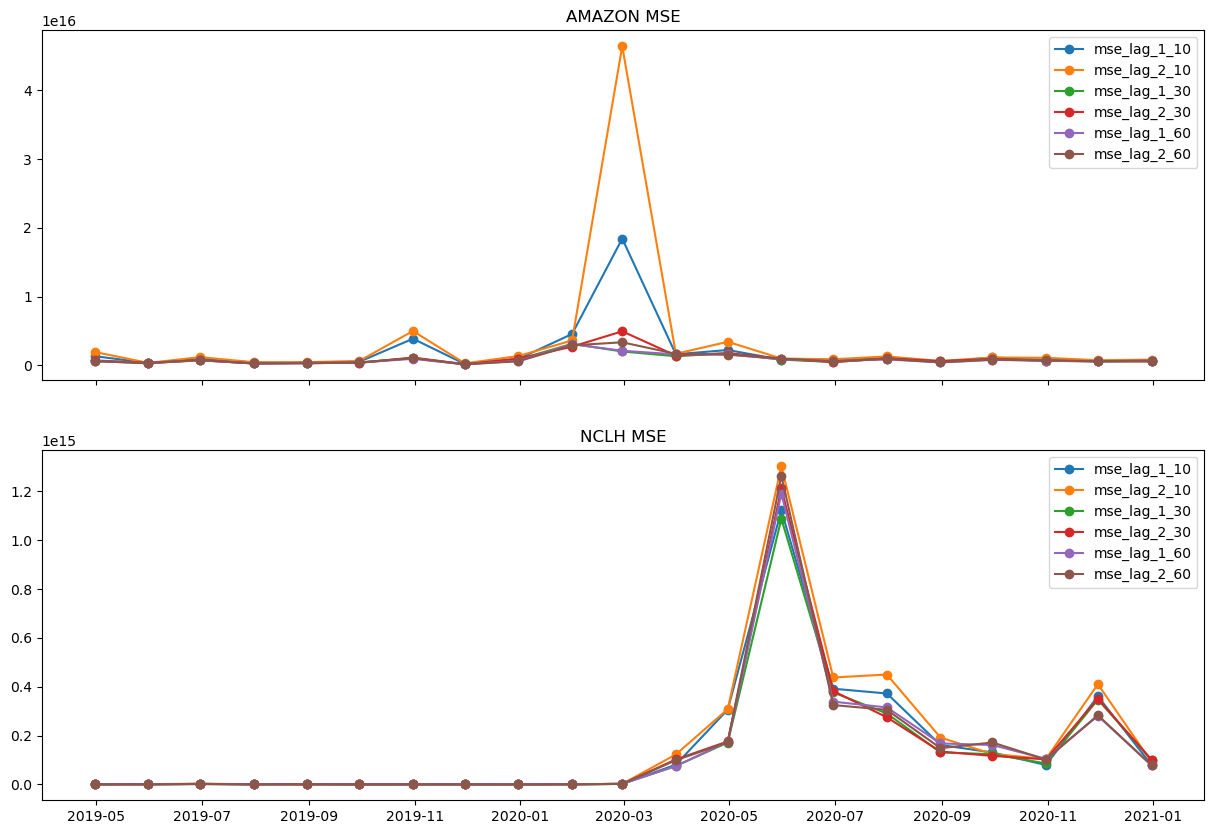

In [20]:
# Plot the results

fig, axs = plt.subplots(figsize=(15, 10), nrows=2, ncols=1, sharex=True)
columns_ = ama_mse_lag.columns
for column in columns_:
    axs[0].plot(ama_mse_lag[column], label=column, marker='o')
    axs[1].plot(nclh_mse_lag[column], label=column, marker='o')

axs[0].set_title('AMAZON MSE')
axs[0].legend(loc='upper right')

axs[1].set_title('NCLH MSE')
axs[1].legend(loc='upper right')

In [21]:
cal = calendar()
holidays = cal.holidays(start='2019-01-01', end='2020-12-31').to_pydatetime()

#compute the mse over the days that are not holidays

ama_vol_lag['is_holiday'] = ama_vol_lag.index.isin(holidays)
nclh_vol_lag['is_holiday'] = nclh_vol_lag.index.isin(holidays)

ama_mse_hol_lag = {}
nclh_mse_hol_lag = {}

for window in window_sizes:
    for lag in [1, 2]:
        ama_mse_hol_lag[f'mse_lag_{lag}_{window}_is_hol'] = ama_vol_lag[ama_vol_lag['is_holiday']][f'mse_lag_{lag}_{window}'].mean()
        ama_mse_hol_lag[f'mse_lag_{lag}_{window}_not_hol'] = ama_vol_lag[~ama_vol_lag['is_holiday']][f'mse_lag_{lag}_{window}'].mean()
        nclh_mse_hol_lag[f'mse_lag_{lag}_{window}_is_hol'] = nclh_vol_lag[nclh_vol_lag['is_holiday']][f'mse_lag_{lag}_{window}'].mean()
        nclh_mse_hol_lag[f'mse_lag_{lag}_{window}_not_hol'] = nclh_vol_lag[~nclh_vol_lag['is_holiday']][f'mse_lag_{lag}_{window}'].mean()


    


ama_hol_df_lag = pd.DataFrame.from_dict(ama_mse_hol_lag, columns=["AMAZON"],   orient='index')
nclh_hol_df_lag = pd.DataFrame.from_dict(nclh_mse_hol_lag, columns=["NCLH"],   orient='index')

hol_df_lag = pd.concat([ama_hol_df_lag, nclh_hol_df_lag], axis=1)

In [22]:
hol_df_lag.head(12)

,AMAZON,NCLH
mse_lag_1_10_is_hol,2.139867e+15,1.581096e+13
mse_lag_1_10_not_hol,1.950274e+15,1.470412e+14
mse_lag_2_10_is_hol,1.774994e+15,8.345350e+13
mse_lag_2_10_not_hol,3.380058e+15,1.683917e+14
mse_lag_1_30_is_hol,1.483077e+15,3.355461e+13
mse_lag_1_30_not_hol,8.938398e+14,1.325462e+14
mse_lag_2_30_is_hol,1.153269e+15,4.892753e+13
mse_lag_2_30_not_hol,1.037432e+15,1.399383e+14
mse_lag_1_60_is_hol,1.713476e+15,3.842689e+13
mse_lag_1_60_not_hol,8.746960e+14,1.370628e+14


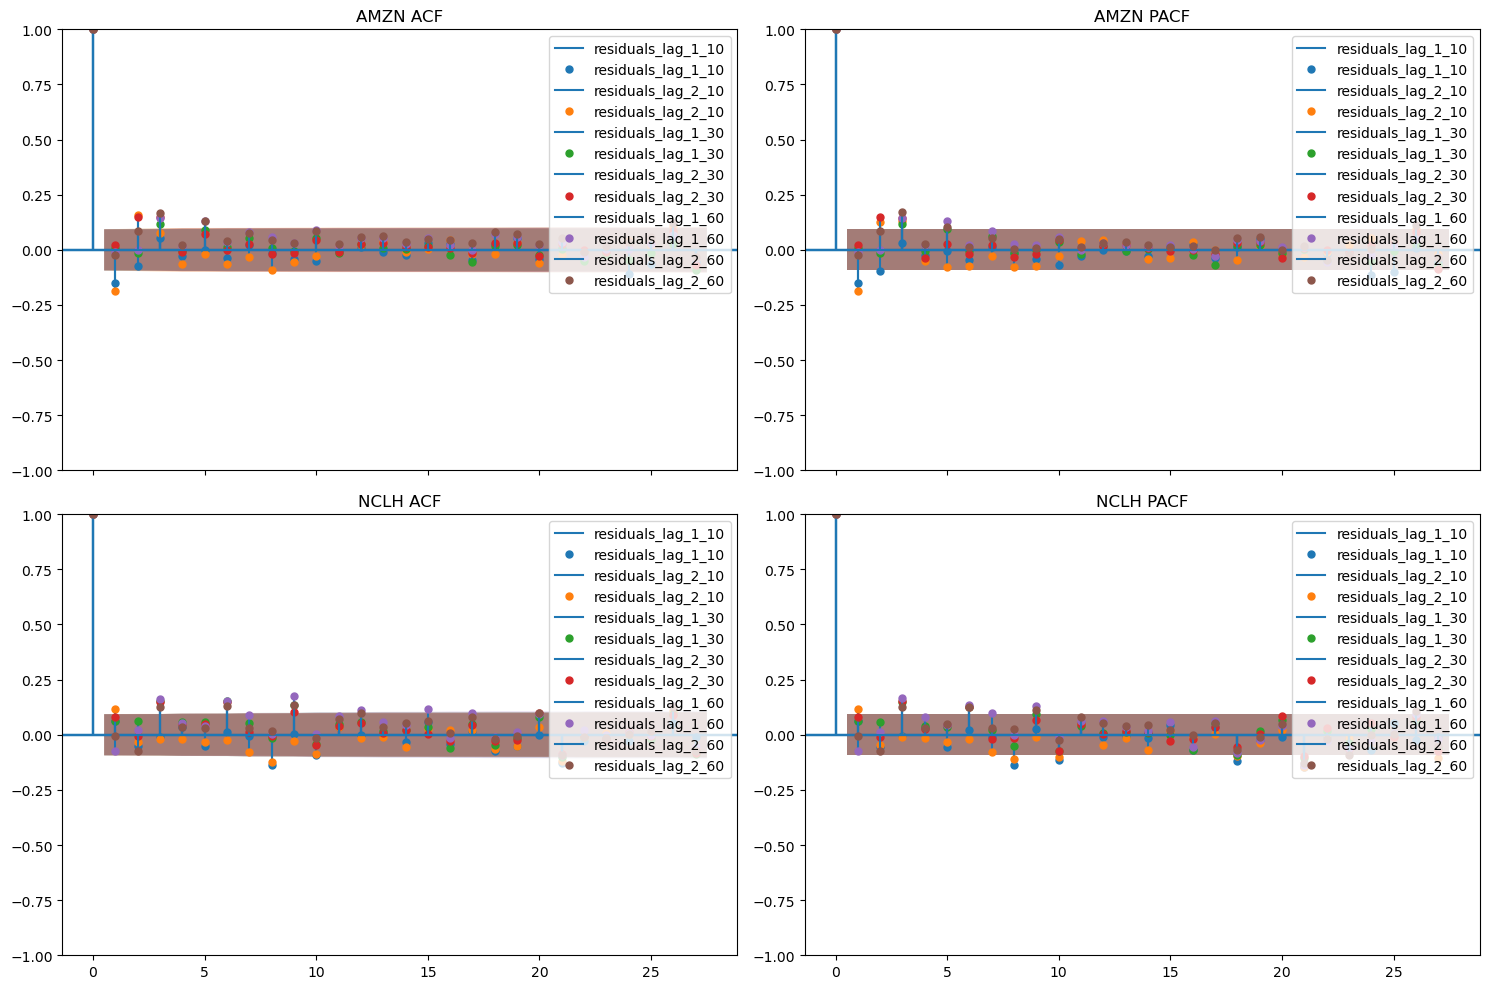

In [23]:
residuals_ama = pd.DataFrame()
residuals_nclh = pd.DataFrame()
for window in window_sizes:
    for lag in [1, 2]:
        residuals_ama[f'residuals_lag_{lag}_{window}'] = ama_vol_lag['Volume'] - ama_vol_lag[f'pred_lag_{lag}_{window}']
        residuals_nclh[f'residuals_lag_{lag}_{window}'] = nclh_vol_lag['Volume'] - nclh_vol_lag[f'pred_lag_{lag}_{window}']


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(figsize=(15, 10), nrows=2, ncols=2, sharex=True)

for column in residuals_ama.columns:
    plot_acf(residuals_ama[column], ax=axs[0,0], label=column)
    plot_pacf(residuals_ama[column], ax=axs[0,1], label=column)
    plot_acf(residuals_nclh[column], ax=axs[1,0], label=column)
    plot_pacf(residuals_nclh[column], ax=axs[1,1], label=column)

axs[0,0].set_title('AMZN ACF')
axs[0,0].legend(loc='upper right')
axs[0,1].set_title('AMZN PACF')
axs[0,1].legend(loc='upper right')
axs[1,0].set_title('NCLH ACF')
axs[1,0].legend(loc='upper right')
axs[1,1].set_title('NCLH PACF')
axs[1,1].legend(loc='upper right')
plt.tight_layout()
plt.show()


- The autocorrelation plots show that no further lags are needed, the first two lags are largeley enough to capture the autocorrelation. This is because the data is very noisy, and the autocorrelation is very low.
- When it comes to wich window size is the best as one could have guessed, during trends, the bigger N the better, but during trend shifts, such as induced by the Covid crisis, smaller windows perform best as they incorporate new information faster. 
- Interestingly,  the models adapt very quickly to the distribution change due to the Covid crsisi, especially for Amazon, where the MSE once the new trend is established i not higher than before. For NCLH, the MSE is larger, but that is also due to the fact that the volumes in themselves are not normalized.
- In terms of holiday/ not holiday, for AMZN, the modle performs better for not holidays systematically. Strangely for NCLH, th emodel performs very well for holidays.


## 4)

In [24]:
##Now using neural networks to predict the stock volumes

ama_nn = data['AMZN'].loc['2019-01-01':'2019-05-31'].copy()
nclh_nn = data['NCLH'].loc['2019-01-01':'2019-05-31'].copy()

In [25]:
ama_nn.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,73.260002,77.667999,73.046501,76.956497,76.956497,159662000
2019-01-03,76.000504,76.900002,74.855499,75.014000,75.014000,139512000
2019-01-04,76.500000,79.699997,75.915497,78.769501,78.769501,183652000
2019-01-07,80.115501,81.727997,79.459503,81.475502,81.475502,159864000
2019-01-08,83.234497,83.830498,80.830498,82.829002,82.829002,177628000


In [26]:
for lag in range(1,5):
    ama_nn[f'lag_{lag}'] = ama_nn['Volume'].shift(lag)
    nclh_nn[f'lag_{lag}'] = nclh_nn['Volume'].shift(lag)

#shift the low, high and close prices beacuse we only have the open price for the day we want to predict

for column in ['Low', 'High', 'Close']:
    ama_nn[column] = ama_nn[column].shift(1)
    nclh_nn[column] = nclh_nn[column].shift(1)


ama_nn.dropna(inplace=True)
nclh_nn.dropna(inplace=True)

ama_nn.head()


,Open,High,Low,Close,Adj Close,Volume,lag_1,lag_2,lag_3,lag_4
Date,,,,,,,,,,
2019-01-08,83.234497,81.727997,79.459503,81.475502,82.829002,177628000,159864000.0,183652000.0,139512000.0,159662000.0
2019-01-09,82.649002,83.830498,80.830498,82.829002,82.971001,126976000,177628000.0,159864000.0,183652000.0,139512000.0
2019-01-10,82.050499,83.389999,82.070000,82.971001,82.810997,130154000,126976000.0,177628000.0,159864000.0,183652000.0
2019-01-11,82.027496,83.162498,81.081001,82.810997,82.028000,93724000,130154000.0,126976000.0,177628000.0,159864000.0
2019-01-14,80.750000,83.014503,81.810997,82.028000,80.860497,120118000,93724000.0,130154000.0,126976000.0,177628000.0


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [28]:
# Just to see how this could work

model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

X = ama_nn.drop(columns=['Volume'])
y = ama_nn['Volume']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'MSE: {mean_squared_error(y_test, y_pred, squared=True):.3e}')

MSE: 3.736e+14


In [ ]:
# now with xgboost
from xgboost import XGBRegressor

num_est_to_depth_to_mse = {}

for num_est in [4, 8, 16, 32, 64, 128]:
    for depth in [2, 4, 6, 8, 16]:
        model = XGBRegressor(n_estimators=num_est, max_depth=depth, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        num_est_to_depth_to_mse[(num_est, depth)] = f"{mean_squared_error(y_test, y_pred, squared=True):.3e}"

print(num_est_to_depth_to_mse)
#printing the pair correpsonding to the lowest mse
print(min(num_est_to_depth_to_mse, key=num_est_to_depth_to_mse.get))

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

X = ama_nn.drop(columns=['Volume']).values
y = ama_nn['Volume'].values



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
batch_size = 16

train_dataset = StockDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = StockDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)   

for batch, (X, y) in enumerate(train_dataloader):
    print(X.shape)
    print(y.shape)
    break



torch.Size([16, 9])
torch.Size([16])


Epoch: 1 | Train Loss: 9.422e+15 | Test Loss: 6.369e+15
Epoch: 2 | Train Loss: 7.536e+15 | Test Loss: 5.067e+15
Epoch: 3 | Train Loss: 6.238e+15 | Test Loss: 3.768e+15
Epoch: 4 | Train Loss: 4.572e+15 | Test Loss: 2.399e+15
Epoch: 5 | Train Loss: 2.882e+15 | Test Loss: 1.162e+15
Epoch: 6 | Train Loss: 1.889e+15 | Test Loss: 4.469e+14
Epoch: 7 | Train Loss: 1.734e+15 | Test Loss: 3.389e+14
Epoch: 8 | Train Loss: 2.462e+15 | Test Loss: 3.451e+14
Epoch: 9 | Train Loss: 2.339e+15 | Test Loss: 3.727e+14
Epoch: 10 | Train Loss: 2.046e+15 | Test Loss: 5.824e+14
Epoch: 11 | Train Loss: 1.946e+15 | Test Loss: 7.056e+14
Epoch: 12 | Train Loss: 2.079e+15 | Test Loss: 6.971e+14
Epoch: 13 | Train Loss: 1.626e+15 | Test Loss: 5.454e+14
Epoch: 14 | Train Loss: 1.900e+15 | Test Loss: 4.495e+14
Epoch: 15 | Train Loss: 1.699e+15 | Test Loss: 4.131e+14
Epoch: 16 | Train Loss: 1.721e+15 | Test Loss: 4.666e+14
Epoch: 17 | Train Loss: 1.382e+15 | Test Loss: 5.188e+14
Epoch: 18 | Train Loss: 1.566e+15 | Test

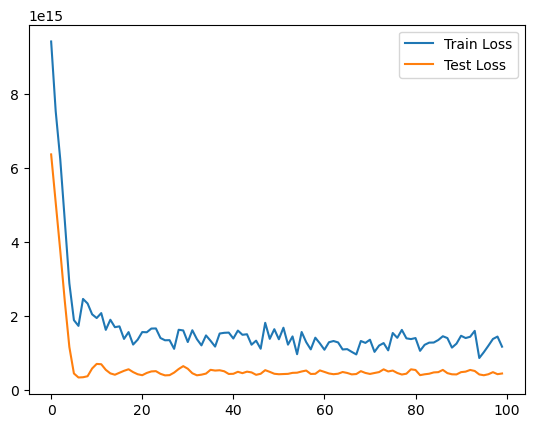

In [43]:
class NeuralNework(nn.Module):
    def __init__(self, input_dim): 
        super(NeuralNework, self).__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 1)

    def forward(self, x):

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x= self.relu(x)
        x = self.dropout(x)

        x = self.fc4(x)
        x = self.relu(x)

        return x
    

model = NeuralNework(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100

train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch, (X, y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss/len(train_dataloader))

    model.eval()
    with torch.no_grad():
        running_test_loss = 0.0
        for batch, (X, y) in enumerate(test_dataloader):
            y_pred = model(X)
            loss = criterion(y_pred, y.unsqueeze(1))
            running_test_loss += loss.item()
    test_losses.append(running_test_loss/len(test_dataloader))

    print(f'Epoch: {epoch+1} | Train Loss: {running_loss/len(train_dataloader):.3e} | Test Loss: {running_test_loss/len(test_dataloader):.3e}')



plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()




- In total I used 5 month of data, from January to May 2020. 80% of it is being used for training, the rest id being used for testing? OF course the data is not shuffled to prevent future data contamination.
- I used a basic multi-layer perceptron with Relu activation functions. 
- Importantly, I used all features available, such as open, close, high, low, and lagged volumes. of course close, high and low were lagged because this is the knid of info you only get at the end of the trading day
- We do beat our benchmark for Amazon

torch.Size([16, 9])
torch.Size([16])
Epoch: 1 | Train Loss: 4.797e+12 | Test Loss: 2.704e+12
Epoch: 2 | Train Loss: 4.190e+12 | Test Loss: 2.307e+12
Epoch: 3 | Train Loss: 3.568e+12 | Test Loss: 1.789e+12
Epoch: 4 | Train Loss: 2.654e+12 | Test Loss: 1.122e+12
Epoch: 5 | Train Loss: 1.734e+12 | Test Loss: 5.552e+11
Epoch: 6 | Train Loss: 1.140e+12 | Test Loss: 4.402e+11
Epoch: 7 | Train Loss: 1.479e+12 | Test Loss: 5.497e+11
Epoch: 8 | Train Loss: 1.295e+12 | Test Loss: 4.920e+11
Epoch: 9 | Train Loss: 1.226e+12 | Test Loss: 4.103e+11
Epoch: 10 | Train Loss: 9.201e+11 | Test Loss: 4.165e+11
Epoch: 11 | Train Loss: 1.087e+12 | Test Loss: 4.303e+11
Epoch: 12 | Train Loss: 1.075e+12 | Test Loss: 4.102e+11
Epoch: 13 | Train Loss: 1.254e+12 | Test Loss: 3.930e+11
Epoch: 14 | Train Loss: 1.029e+12 | Test Loss: 3.919e+11
Epoch: 15 | Train Loss: 9.529e+11 | Test Loss: 3.904e+11
Epoch: 16 | Train Loss: 7.801e+11 | Test Loss: 3.885e+11
Epoch: 17 | Train Loss: 9.529e+11 | Test Loss: 3.865e+11
Epo

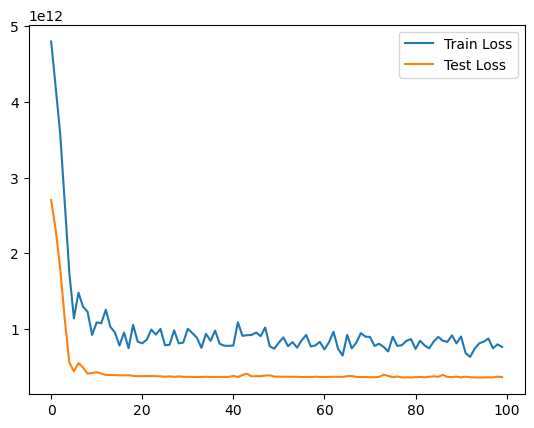

In [44]:
#Now, for NCLH

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

X = nclh_nn.drop(columns=['Volume']).values
y = nclh_nn['Volume'].values



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    
batch_size = 16

train_dataset = StockDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = StockDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)   

for batch, (X, y) in enumerate(train_dataloader):
    print(X.shape)
    print(y.shape)
    break

model = NeuralNework(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100

train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch, (X, y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss/len(train_dataloader))

    model.eval()
    with torch.no_grad():
        running_test_loss = 0.0
        for batch, (X, y) in enumerate(test_dataloader):
            y_pred = model(X)
            loss = criterion(y_pred, y.unsqueeze(1))
            running_test_loss += loss.item()
    test_losses.append(running_test_loss/len(test_dataloader))

    print(f'Epoch: {epoch+1} | Train Loss: {running_loss/len(train_dataloader):.3e} | Test Loss: {running_test_loss/len(test_dataloader):.3e}')



plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()


Same thing, we also beat benchmark for NCLH

## 5)

Indeed, to predict the volume on banking holidays, we need more data as the holidays are rather rare in a year. Then, using an additional feature to indicate whether it is a holiday or not would be a good idea.